In [18]:
import tables 
import matplotlib.pyplot as plt
import numpy as np

In [19]:
hfile = tables.open_file("Data/dl1_5205_10.h5","r")

In [20]:
hfile

File(filename=Data/dl1_5205_10.h5, title='', mode='r', root_uep='/', filters=Filters(complevel=0, shuffle=False, bitshuffle=False, fletcher32=False, least_significant_digit=None))
/ (RootGroup) ''
/configuration (Group) 'Simulation, telescope and subarray configuration.'
/dl1 (Group) ''
/dl1/event (Group) ''
/dl1/event/subarray (Group) ''
/dl1/event/subarray/trigger (Table(10000,)) ''
  description := {
  "event_id": UInt64Col(shape=(), dflt=0, pos=0),
  "event_type": UInt64Col(shape=(), dflt=0, pos=1),
  "obs_id": UInt64Col(shape=(), dflt=0, pos=2),
  "time": Float64Col(shape=(), dflt=0.0, pos=3),
  "timestamp_s": UInt32Col(shape=(), dflt=0, pos=4),
  "timestamp_qns": UInt32Col(shape=(), dflt=0, pos=5)}
  byteorder := 'little'
  chunkshape := (1638,)
/dl1/event/telescope (Group) ''
/dl1/event/telescope/images (Group) ''
/dl1/event/telescope/images/tel_001 (Table(10000,)) ''
  description := {
  "event_id": UInt64Col(shape=(), dflt=0, pos=0),
  "obs_id": UInt64Col(shape=(), dflt=0, pos

In [21]:
image = hfile.root.dl1.event.telescope.images.tel_001.col("image")
image.shape

(10000, 1855)

In [22]:
tab_order_pixel = hfile.root.configuration.instrument.telescope.camera.pixel_order.tel_001.read()

In [23]:
tabx = hfile.root.configuration.instrument.telescope.camera.geometry_LSTCam.col("pix_x")[tab_order_pixel]
taby = hfile.root.configuration.instrument.telescope.camera.geometry_LSTCam.col("pix_y")[tab_order_pixel]
htable = np.fromfile("injunction_table_lst.pny", offset=8, dtype=np.uint16)[tab_order_pixel] # construire un tableau à partir des données d'un fichier binaire

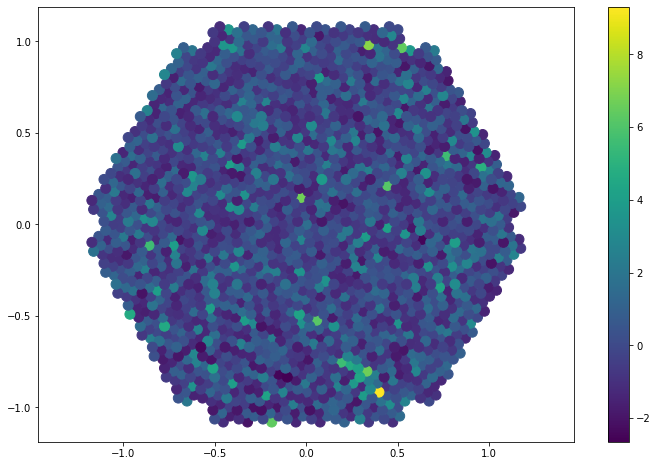

In [24]:
plt.figure(figsize=(12,8))
plt.scatter(tabx,taby,c=image[0],s=100)
plt.colorbar()
plt.axis("equal")
plt.show()

In [25]:
tab_good_event = [event for event in image if event.std()>30]
print(len(tab_good_event))

10


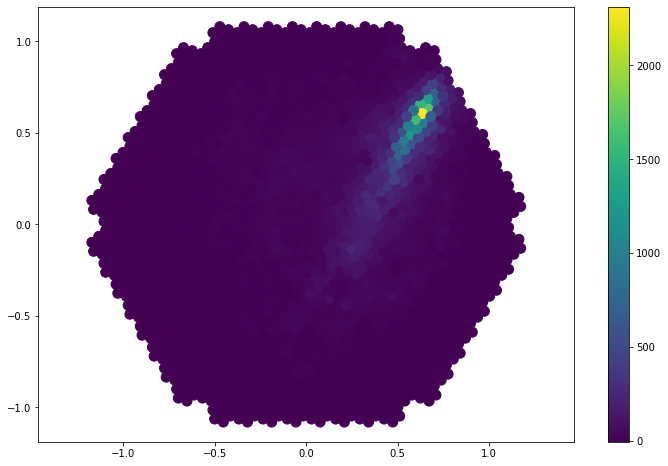

In [26]:
plt.figure(figsize=(12,8))
plt.scatter(tabx,taby,c=tab_good_event[0],s=100)
plt.colorbar()
plt.axis("equal")
plt.show()

In [27]:
matrix = np.zeros(55*55)

In [28]:
matrix[htable] = tab_good_event[0]

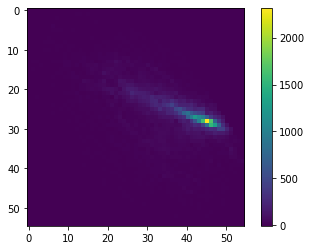

In [29]:
res = matrix.reshape(55,55)
plt.imshow(res)
plt.colorbar()

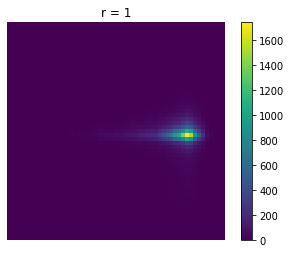

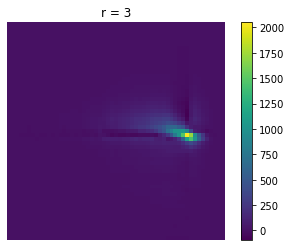

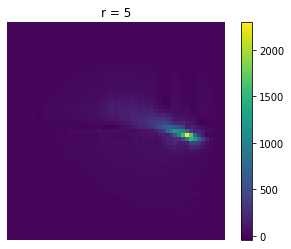

In [40]:
# Applying SVD
U, S, VT = np.linalg.svd(res,full_matrices=False,# It's not necessary to compute the full matrix of U or V
      compute_uv=True) # Deterministic SVD

S = np.diag(S)

j = 0
# Approximation d'image au rang r
for r in (1, 3, 5):
    # Construct approximate image
    Xapprox = U[:,:r] @ S[0:r,:r] @ VT[:r,:]
    plt.figure(j+1)
    j += 1
    img = plt.imshow(Xapprox)
    plt.imsave('hashimg'+str(r)+'.png' , Xapprox)
    plt.colorbar()
    plt.axis('off')
    plt.title('r = ' + str(r))
    plt.show()

# En gardant seulement les 3 ou 5 premières colonnes de U et VT et S en 3x3 on reconstruit exactement notre image précédente

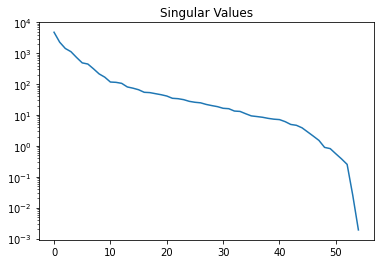

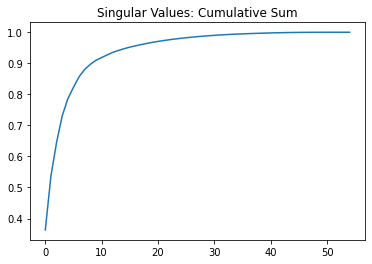

In [31]:
plt.figure(1)
plt.semilogy(np.diag(S)) #mise à l'échelle logarithmique sur l'axe y des valeurs singulières
plt.title('Singular Values')
plt.show()

plt.figure(2)
plt.plot(np.cumsum(np.diag(S))/np.sum(np.diag(S))) # La fraction d'énergie capturée par les premières modes r allant de 0 à 100%
plt.title('Singular Values: Cumulative Sum')
plt.show()

In [32]:
# Let's apply pca now to compare with svd
from sklearn.decomposition import PCA

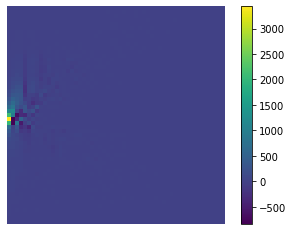

In [33]:
def pca(X):
  # Data matrix X, assumes 0-centered
  n, m = X.shape
  #assert np.allclose(X.mean(axis=0), np.zeros(m))
  # Compute covariance matrix
  C = np.dot(X.T, X) / (n-1)
  # Eigen decomposition
  eigen_vals, eigen_vecs = np.linalg.eig(C)
  # Project X onto PC space
  X_pca = np.dot(X, eigen_vecs)
  return X_pca, eigen_vals

p, vp = pca(res)
plt.imshow(p)
plt.colorbar()
plt.axis('off')
plt.show()

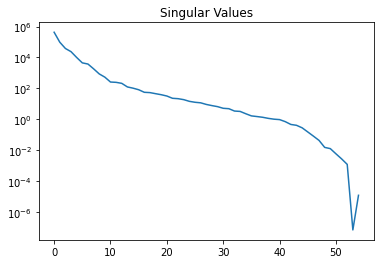

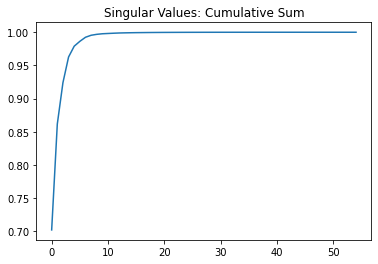

In [34]:
plt.figure(1)
plt.semilogy(vp) #mise à l'échelle logarithmique sur l'axe y des valeurs singulières
plt.title('Singular Values')
plt.show()

plt.figure(2)
plt.plot(np.cumsum(vp)/np.sum(vp)) # La fraction d'énergie capturée par les premières modes r allant de 0 à 100%
plt.title('Singular Values: Cumulative Sum')
plt.show()